<a href="https://colab.research.google.com/github/Aspartia/BIGDATA/blob/main/4_gyakorlat_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Big Data algoritmusok és programozás - Python</h1>

# Párhuzamos feldolgozás - MapReduce - Mrjob #

Google Colab

## 1. Az adathalmazok és vizsgálatuk

### `Salaries` adathalmaz

A `Salaries.csv` adathalmazt használjuk. Olvassuk be és készítsünk pandas DataFrame-et, majd vizsgáljuk meg az adathalmazt.

In [34]:
import pandas as pd

In [35]:
df = pd.read_csv('Salaries.csv' )

In [36]:
df.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,NaN,567595.43,567595.43,2011.0,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011.0,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,335279.91,2011.0,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,332343.61,2011.0,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,326373.19,2011.0,NaN,San Francisco,NaN


In [37]:
df.shape

(9854, 13)

Számoljuk meg, hányszor fordul elő egy adott string (`'MANAGER'`) egy adott oszlopban (`'JobTitle'`). Ehhez használhatjuk a `Series.str.count()` metódust.

In [38]:
df['JobTitle'].str.count('MANAGER')

0       1.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9849    0.0
9850    0.0
9851    0.0
9852    0.0
9853    NaN
Name: JobTitle, Length: 9854, dtype: float64

In [39]:
total_MANAGER_occurrences = df['JobTitle'].str.count('MANAGER').sum()

In [40]:
total_MANAGER_occurrences

821.0

Oldjuk meg az előző feladatot case insensitive módon (transzformáljuk kisbetűssé a `JobTitle` oszlop értékeit).

In [41]:

df['JobTitle'] = df['JobTitle'].str.lower()


In [42]:
total_manager_occurrences = df['JobTitle'].str.count('manager').sum()

Készítsünk egy dictionary-t, amelyben a különböző beosztások előfordulását adjuk meg.

In [43]:
frequency = {}

In [44]:
frequency['manager'] = df['JobTitle'].str.count('manager').sum()
frequency['deputy chief'] = df['JobTitle'].str.count('deputy chief').sum()
frequency['captain'] = df['JobTitle'].str.count('captain').sum()

In [46]:
frequency

{'manager': 821.0, 'deputy chief': 13.0, 'captain': 137.0}

### `Jobs` adathalmaz

Készítsünk egy dictionary-t, amely a `Jobs.csv` fájlban található összes beosztás előfordulását tartalmazza.

- Olvassuk be a `Jobs.csv` fájlt.
- Készítsünk egy ciklust az összes a `Job` oszlopban levő beosztás gyakoriságának meghatározásához.

In [47]:
jobs = pd.read_csv('Jobs.csv')

In [48]:
jobs

,Job
0,manager
1,captain
2,director
3,assistant
4,inspector
5,administrator
6,deputy chief
7,department head


In [49]:
frequency = {} #üres dictionary

In [50]:
for job_name in jobs['Job']:
    frequency[job_name] = df['JobTitle'].str.count(job_name).sum()

In [51]:
frequency

{'manager': 821.0,
 'captain': 137.0,
 'director': 152.0,
 'assistant': 142.0,
 'inspector': 417.0,
 'administrator': 37.0,
 'deputy chief': 13.0,
 'department head': 36.0}

### `Count_jobs` függvény (beosztások előfordulásának megszámlálása)

Készítsünk függvényt `count_jobs` néven a kódunkból, amelynek 2 argumentuma van:

*   `data` az adatokat tartalmazó DataFrame és
*   `jobs` a beosztásokat tartalmazó Series.




In [52]:
def count_jobs(data,jobs):
    frequency = {}
    for job_name in jobs["Job"]:
        frequency[job_name] = data["JobTitle"].str.count(job_name).sum()
    return frequency

In [53]:
freq = count_jobs(df,jobs)
freq

{'manager': 821.0,
 'captain': 137.0,
 'director': 152.0,
 'assistant': 142.0,
 'inspector': 417.0,
 'administrator': 37.0,
 'deputy chief': 13.0,
 'department head': 36.0}

## 2. Párhuzamos feldolgozás

Valósítsuk meg mindezt párhuzamos feldolgozással.

### Adathalmaz felosztása

Ha párhuzamos feldolgozást használunk, akkor az adatokat részekre (chunk) osztjuk, és minden egyes részt átadunk a `count_jobs` függvénynek.

- Készítsünk függvényt (`make_chunks`), amelynek argumentumai: `df` a felosztandó adathalmaz (DataFrame) és `num_chunk` a chunk-ok száma.

- A függvény visszatérési értéke egy DataFrame lista (hossza a chunk-ok száma).
- A chunk-ok méretét a következőképpen számolhatjuk:
```python
chunk_size = math.ceil(num_rows / num_chunks)
```
(A `math.ceil()` függvény kerekítést végez.)
- A chunk lista készítése:
```python
chunks = []
for i in range(0, num_rows, chunk_size):
    chunks.append(df[i: i + chunk_size])
```

  Redukálhatjuk a kódot (list comprehension):
```python
chunks = [df[i:i+chunk_size] for i in range(0, num_rows, chunk_size)]
```






In [54]:
import math

In [55]:
def make_chunks(df, num_chunks):
    num_rows = df.shape[0]
    chunk_size = math.ceil(num_rows / num_chunks)
    return [df[i:i+chunk_size] for i in range(0, num_rows, chunk_size)]

In [56]:
df_chunks = make_chunks(df, 10)

In [57]:
df_chunks

[      Id       EmployeeName                                        JobTitle  \
 0      1     NATHANIEL FORD  general manager-metropolitan transit authority   
 1      2       GARY JIMENEZ                 captain iii (police department)   
 2      3     ALBERT PARDINI                 captain iii (police department)   
 3      4  CHRISTOPHER CHONG            wire rope cable maintenance mechanic   
 4      5    PATRICK GARDNER    deputy chief of department,(fire department)   
 ..   ...                ...                                             ...   
 981  982    WILLIAM WYCKOFF                                     firefighter   
 982  983     CHARLES MC COY                     lieutenant, fire department   
 983  984     MICHAEL HASTEY                          fire fighter paramedic   
 984  985          PEIYUE HO                      diagnostic imaging tech ii   
 985  986      CAROL WOLTHER            electrical transit shop supervisor i   
 
        BasePay  OvertimePay   OtherPa

In [58]:
df_chunks[0]

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,general manager-metropolitan transit authority,167411.18,0.00,400184.25,NaN,567595.43,567595.43,2011.0,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,captain iii (police department),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011.0,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,captain iii (police department),212739.13,106088.18,16452.60,NaN,335279.91,335279.91,2011.0,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,wire rope cable maintenance mechanic,77916.00,56120.71,198306.90,NaN,332343.61,332343.61,2011.0,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"deputy chief of department,(fire department)",134401.60,9737.00,182234.59,NaN,326373.19,326373.19,2011.0,NaN,San Francisco,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,982,WILLIAM WYCKOFF,firefighter,105934.64,52697.70,11553.27,NaN,170185.61,170185.61,2011.0,NaN,San Francisco,NaN
982,983,CHARLES MC COY,"lieutenant, fire department",123105.00,31227.51,15842.22,NaN,170174.73,170174.73,2011.0,NaN,San Francisco,NaN
983,984,MICHAEL HASTEY,fire fighter paramedic,122405.00,32171.52,15551.55,NaN,170128.07,170128.07,2011.0,NaN,San Francisco,NaN
984,985,PEIYUE HO,diagnostic imaging tech ii,103971.40,23945.61,42208.30,NaN,170125.31,170125.31,2011.0,NaN,San Francisco,NaN


### Processzek párhuzamos futtatása

A párhuzamos feldolgozás további lépései

- Készítsünk process listát, minden chunk-ra egyet

- Futtasuk a processzeinket

- Gyűjtsük össze az eredményeket és egyesítsük azokat egyetlen gyakorisági táblázatba

Ehhez a `concurrent.futures` modult használjuk. Ez a modul lehetővé teszi több processz futtatását, és egyes processzek eredményéből egy listát készít.

A `concurrent.futures` modul dokumentációja: https://docs.python.org/3/library/concurrent.futures.html


---
A `concurrent.futures` modul működése egy egyszerű példán.

Legyen egy `string_mult()` függvényünk, amely egy adott stringet megadott számszor megtöbbszöröz:


In [59]:
def string_mult(string, times):
    return string * times

In [69]:
# a függvény kipróbálása
string_mult('abc',10)
#print('abc'*10)

'abcabcabcabcabcabcabcabcabcabc'

Alkalmazzuk a `string_mult()` függvényt a `concurrent.futures` modulban egy lista (`['a', 'b', 'c', 'd']`) elemeire.

Ehhez használjuk a `concurrent.futures.ProcessPoolExecutor` osztályt.


In [60]:
strings = ['a', 'b', 'c', 'd']
times = 3

In [72]:
import concurrent.futures

A `ProcessPoolExecutor()` `submit()` függvénye végrehajt egy függvényt. Első argumentuma a futtatandó függvény neve, azután a függvényargumentumok következnek vesszővel elválasztva.

In [73]:
concurrent.futures.ProcessPoolExecutor().submit(string_mult, 'abcd', times)

<Future at 0x7ced2c603190 state=running>

Az `executor.submit()` függvény által létrehozott objektumok `Future` típusúak.
A `Future.result()` metódus segítségével megkaphatjuk a visszatérési értékeket.

In [74]:
concurrent.futures.ProcessPoolExecutor().submit(string_mult, 'abcd', times).result()

'abcdabcdabcd'

Alkalmazzuk mindezt a `string` listánkra.

In [64]:
with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = [executor.submit(string_mult, string, times) for string in strings]

In [75]:
futures

[<Future at 0x7ced264c3670 state=finished returned str>,
 <Future at 0x7ced264c3d30 state=finished returned str>,
 <Future at 0x7ced264c3df0 state=finished returned str>,
 <Future at 0x7ced264c3eb0 state=finished returned str>]

In [76]:
futures[0].result()

'aaa'

In [77]:
results = [future.result() for future in futures]
results

['aaa', 'bbb', 'ccc', 'ddd']

Mindez összefoglalható egy függvényben.

In [78]:
def parallel(function, strings, times):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(function, string, times) for string in strings]
    return [future.result() for future in futures]

In [79]:
results = parallel(string_mult, ['1','2','3'], 10)
results

['1111111111', '2222222222', '3333333333']

---
Alkalmazzuk mindezt a kiindulási problémára (beosztások gyakoriságának meghatározása).

In [87]:
def count_jobs_parallel(function, data, sequence): ## itt már chunkokra vannak dobálva az adatok
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(function, chunk, sequence) for chunk in data]
    return [future.result() for future in futures]

In [89]:
# a függvény alkalmazása a beosztások gyakoriságának megszámlálására
frequency = count_jobs_parallel(count jobs, df_chunks, jobs)
print(frequency)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-89-cfb164ffebc7>, line 2)

Egészítsük ki a függvényünket egy további argumentummal, a processzek számával.

In [84]:
def count_jobs_parallel_mod(function, data, sequence, num_processes):
    chunks = make_chunks(data, num_processes)
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(function, chunk, sequence) for chunk in chunks]
    return [future.result() for future in futures]

In [93]:
# a függvény alkalmazása a beosztások gyakoriságának megszámlálására
frequency = count_jobs_parallel_mod(count_jobs, df, jobs,10)
print(frequency)

[{'manager': 81, 'captain': 90, 'director': 48, 'assistant': 42, 'inspector': 46, 'administrator': 2, 'deputy chief': 13, 'department head': 19}, {'manager': 88, 'captain': 26, 'director': 15, 'assistant': 17, 'inspector': 45, 'administrator': 0, 'deputy chief': 0, 'department head': 7}, {'manager': 117, 'captain': 13, 'director': 11, 'assistant': 11, 'inspector': 70, 'administrator': 1, 'deputy chief': 0, 'department head': 1}, {'manager': 104, 'captain': 3, 'director': 17, 'assistant': 11, 'inspector': 45, 'administrator': 1, 'deputy chief': 0, 'department head': 5}, {'manager': 48, 'captain': 3, 'director': 29, 'assistant': 10, 'inspector': 21, 'administrator': 0, 'deputy chief': 0, 'department head': 1}, {'manager': 116, 'captain': 0, 'director': 14, 'assistant': 7, 'inspector': 10, 'administrator': 1, 'deputy chief': 0, 'department head': 1}, {'manager': 90, 'captain': 0, 'director': 6, 'assistant': 10, 'inspector': 19, 'administrator': 2, 'deputy chief': 0, 'department head': 0},

### Eredmények kombinálása

Python | Sum list of dictionaries with same key: https://www.geeksforgeeks.org/python-sum-list-of-dictionaries-with-same-key/
> Method #1: Using reduce() + operator



In [94]:
import collections, functools, operator

frequency_sum = dict(functools.reduce(operator.add,
         map(collections.Counter, frequency)))
print(frequency_sum)

{'manager': 821.0, 'captain': 137.0, 'director': 152.0, 'assistant': 142.0, 'inspector': 417.0, 'administrator': 37.0, 'deputy chief': 13.0, 'department head': 36.0}


---
## 3. MapReduce

Készítsünk saját MapReduce keretrendszert.

- Split: az adatok felosztása részekre (chunks).

- Map: párhuzamos feldolgozás minden részre.

- Reduce: az egyes részek eredményeinek kombinálása - globális eredmény.



###Példa

MapReduce segítségével egy számlistában a maximális érték kiszámításának lépései.

1.   Split: a `make_chunks()` függvény használata a lista kisebb darabokra bontásához.
2.   Map: adott chunk-ra a maximális érték meghatározása (ehhez használható a `max()` beépített függvény).
3. Reduce: eredmények összesítése.


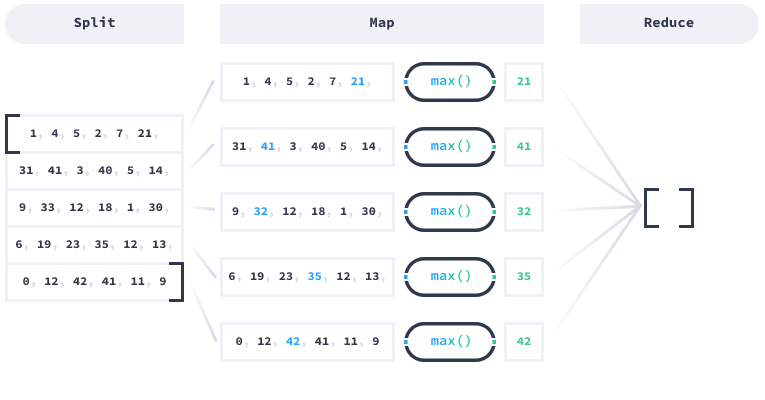


In [95]:
values = [1, 4, 5, 2, 7, 21,     \
          31, 41, 3, 40, 5, 14,  \
          9, 32, 12, 18, 1, 30,  \
          6, 19, 23, 35, 12, 13, \
          0, 12, 42, 41, 11, 9]

### Split

Korábban használtuk:

```python
def make_chunks(df, num_chunks):
    chunk_size = math.ceil(df.shape[0] / num_chunks)
    return [df[i:i+chunk_size] for i in range(0, df.shape[0], chunk_size)]
```

általánosítás: `df.shape` helyett `len()` - DataFrame-ek mellett listákra és egyéb python objektumokra is használható


In [96]:
def make_chunks(data, num_chunks):
    chunk_size = math.ceil(len(data) / num_chunks)
    return [data[i:i+chunk_size] for i in range(0, len(data), chunk_size)]

In [112]:
chunks = make_chunks(values, 5) # itt állítható  a szám !!!

In [113]:
chunks

[[1, 4, 5, 2, 7, 21],
 [31, 41, 3, 40, 5, 14],
 [9, 32, 12, 18, 1, 30],
 [6, 19, 23, 35, 12, 13],
 [0, 12, 42, 41, 11, 9]]

### Map

#### `map_parallel()` függvény készítése

Korábban használt `count_jobs_parallel_mod` függvény általánosítása:

```python
def count_jobs_parallel_mod(function, data, num_processes):
    chunks = make_chunks(data, num_processes)
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(function, chunk) for chunk in chunks]
    return [future.result() for future in futures]
```

A `map_parallel()` függvénynek három paramétere lesz:

- mapper: a függvény, amelyet alkalmazni szeretnénk a részeken (chunk) - a fenti példában ez a `max()` függvény

- data: az adat

- num_processes: a processzek száma

In [117]:
def map_parallel(mapper, data, num_processes):
    chunks = make_chunks(data, num_processes)
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(mapper, chunk) for chunk in chunks]
    return [future.result() for future in futures]

Hívjuk meg a `map_parallel()` függvényt a következő paraméterekkel:
- mapper: a `max()` beépített függvény
- data: `values` értéklista
- num_processes: 5

In [116]:
results= map_parallel(max,values,5)
results

[21, 41, 32, 35, 42]

#### Másik módszer: `Pool` használata

Multiprocessing — Process-based parallelism: https://docs.python.org/3/library/multiprocessing.html

A `multiprocessing` modul `Pool` objektumának használatával:

```python
from multiprocessing import Pool
pool = Pool(num_processes)
```

Ha nem adjuk meg a processzek számát, akkor automatikusan az `os.cpu_count()` értékre áll be, ami a CPU-k száma (Colab vagy saját gép használata esetén a gépünkön):

```python
import os
print(os.cpu_count())
```

```python
import multiprocessing
multiprocessing.cpu_count()
```

In [100]:
import os
print(os.cpu_count())

2


In [101]:
from multiprocessing import Pool
pool = Pool()
pool

<multiprocessing.pool.Pool state=RUN pool_size=2>

In [102]:
pool = Pool(3)
pool

<multiprocessing.pool.Pool state=RUN pool_size=3>

A `Pool.map()` metódus segítségével párhuzamosan futtathatunk függvényeket adatdarabokon.

Példa a `Pool.map()` használatára - a `sum()` függvény párhuzamos alkalmazása listák listájára:

In [103]:
sums = pool.map(sum, [[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(sums)

[6, 15, 24]


A korábbi ábrán levő példa esetén:

In [104]:
print(values)

[1, 4, 5, 2, 7, 21, 31, 41, 3, 40, 5, 14, 9, 32, 12, 18, 1, 30, 6, 19, 23, 35, 12, 13, 0, 12, 42, 41, 11, 9]


In [105]:
chunks = make_chunks(values, 4)
chunks

[[1, 4, 5, 2, 7, 21, 31, 41],
 [3, 40, 5, 14, 9, 32, 12, 18],
 [1, 30, 6, 19, 23, 35, 12, 13],
 [0, 12, 42, 41, 11, 9]]

In [106]:
with Pool(4) as pool:
    results = pool.map(max, chunks)

In [107]:
results

[41, 40, 35, 42]

### Reduce

A `functools` modul `reduce` függvényét használhatjuk. A `functools.reduce()` függvénynek két argumentuma van:

- a reducer függvény
- lista, amelyen a reducer függvényt alkalmazzuk

Példa: reducer függvény az `add()` függvény, amely két számot összead:



In [118]:
def add(x, y):
    return x + y

In [119]:
#import functools
print(functools.reduce(add, [5, 7, 3, 9, 4, 6]))

34


A `functools.reduce()` függvény alkalmazása a korábbi ábrán látható példára (a reducer függvény a `max` függvény):

In [120]:
# a map utáni eredmény
results

[21, 41, 32, 35, 42]

In [125]:
max_value= functools.reduce(max,results)
max_value

42

### Saját MapReduce keretrendszer készítése

A korábbi ábrán látható példa (számlista maximális értékének meghatározása) megoldása.

1. Adatok felosztása a `make_chunks()` függvény használatával
2. Minden részhalmaz maximumának meghatározása a `Pool.map()` metódussal
3. Az eredmények kombinálása a `functools.reduce()` függvény használatával

In [121]:
print(values)

[1, 4, 5, 2, 7, 21, 31, 41, 3, 40, 5, 14, 9, 32, 12, 18, 1, 30, 6, 19, 23, 35, 12, 13, 0, 12, 42, 41, 11, 9]


In [122]:
num_processes = 5

In [123]:
chunks = make_chunks(values, num_processes)

with Pool(num_processes) as pool:
    chunk_results = pool.map(max, chunks)

overall_result = functools.reduce(max, chunk_results)

In [124]:
overall_result

42

**Minden lépést tegyünk bele egy függvénybe**

`map_reduce()` függvény készítése, amely bármely adathalmazon alkalmazható. Ennek paraméterei:

1. adathalmaz: `data`
2. folyamatok száma (chunk-ok száma): `num_processes`
3. a chunk-okra alkalmazandó függvény: `mapper`
4. a chunk-ok eredményeit kombináló függvény: `reducer`

In [128]:
def map_reduce(data,map_processes,mapper,reducer):
  chunks= make_chunks(data,num_processes)
  with Pool(map_processes) as pool:
    chunk_results =pool.map(mapper, chunks)
  return functools.reduce(reducer,chunk_results)

A `map_reduce()` függvény használata a korábbi képen levő példára (számok maximumának meghatározása):

In [130]:
max_value = map_reduce(values,5,max,max)
max_value

42

**Feladat:** A `map_reduce()` függvény használata a számok minimumának meghatározására.

In [132]:
min_value =map_reduce(values,5,min,min)
min_value

0

**Feladat:** A `map_reduce()` függvény használata a számok összegének meghatározására.

In [135]:
sum_value= map_reduce(values,5,sum,add)
sum_value

499

In [136]:
sum_value= map_reduce(values,5,sum,(lambda x,y : x+y))
sum_value

499

---
**Kiindulási példa megoldása a `map_reduce()` függvény használatával.**

1. változat (`jobs` DataFrame particionálásával)

- `mapper()` függvény definiálása

- `reducer()` függvény definiálása (két argumentuma: `dict1`, `dict2` - a két rész gyakoriság-táblái (különböző kulcsokkal), ezeket egyesíti a `dict.update()` metódussal)

- `map_reduce()` függvény meghívása négy argumentummal: jobs, 4, mapper, reducer

In [137]:
#import pandas as pd

In [138]:
#df = pd.read_csv("Salaries.csv")

In [139]:
#df["JobTitle"] = df["JobTitle"].str.lower()

In [140]:
#jobs = pd.read_csv("Jobs.csv")

In [142]:
def mapper(job_chunk):
    frequency = {}
    for job_name in job_chunk["Job"]:
        frequency[job_name] = df["JobTitle"].str.count(job_name).sum()
    return frequency

def reducer(dict1, dict2):
    merged = {}
    merged.update(dict1)
    merged.update(dict2)
    return merged

In [143]:
job_freq = map_reduce(jobs, 4, mapper, reducer)

In [144]:
job_freq

{'manager': 821.0,
 'captain': 137.0,
 'director': 152.0,
 'assistant': 142.0,
 'inspector': 417.0,
 'administrator': 37.0,
 'deputy chief': 13.0,
 'department head': 36.0}

2. változat (`df` DataFrame - salaries - particionálásával)

- `mapper_df()` függvény definiálása

- `reducer_df()` függvény definiálása (két argumentuma: `dict1`, `dict2` dictionary - az azonos kulcsokhoz tartozó értékeket összegzi)

- `map_reduce()` függvény meghívása négy argumentummal: df, 4, mapper_df, reducer_df

In [145]:
def mapper_df(data_chunk):
    frequency = {}
    for job_name in jobs["Job"]:
        frequency[job_name] = data_chunk["JobTitle"].str.count(job_name).sum()
    return frequency

def reducer_df(dict1, dict2):
    sumdict = {}
    for key in dict1:
      sumdict[key] = dict1[key] + dict2[key]
    return sumdict

def reducer_df2(dict1, dict2):
    for key in dict2:
      if key in dict1:
        dict1[key] += dict2[key]
      else:
        dict1[key] = dict2[key]
    return dict1

In [146]:
job_freq_2 = map_reduce(df, 4, mapper_df, reducer_df)
job_freq_2

{'manager': 821.0,
 'captain': 137.0,
 'director': 152.0,
 'assistant': 142.0,
 'inspector': 417.0,
 'administrator': 37.0,
 'deputy chief': 13.0,
 'department head': 36.0}

**Feladat:** A `map_reduce()` függvény használata a `beer.txt` szavainak megszámlálására.

In [147]:
words = []
with open("beer.txt",'r') as file:
    for line in file:
      for word in line.split():
        words.append(word)
print(words[0:7],'\n',words[7:11],'\n',words[11:19],'\n',words[19:26])

['100', 'bottles', 'of', 'beer', 'on', 'the', 'wall'] 
 ['100', 'bottles', 'of', 'beer'] 
 ['You', 'take', 'one', 'down', 'and', 'pass', 'it', 'around'] 
 ['99', 'bottles', 'of', 'beer', 'on', 'the', 'wall.']


In [ ]:
# mapper_beer és reducer_beer függvények definiálása
words= []
with open('beer.txt') as file:
  for line in file:
    for word in line.split():
      words.append(word)
print_words([0:7], '\n'  ) ##

In [148]:
# map_reduce alkalmazása

def mapper_beer(words_chunk):
  frequency={}
  for word in words_chunk:
    if not word in frequency:
      frequency[word] =0
    frequency[word] +=1
  return frequency

def reducer_beer(dict1,dict2):
  for key in dict2:
    if key in dict1:
      dict1[key] += dict2[key]
    else:
      dict1[key] = dict2[key]
  return dict1



In [150]:
word_counts =map_reduce(words,4,mapper_beer,reducer_beer)
word_counts

{'100': 2,
 'bottles': 298,
 'of': 300,
 'beer': 300,
 'on': 200,
 'the': 200,
 'wall': 100,
 'You': 100,
 'take': 100,
 'one': 100,
 'down': 100,
 'and': 100,
 'pass': 100,
 'it': 100,
 'around': 100,
 '99': 3,
 'wall.': 100,
 '98': 3,
 '97': 3,
 '96': 3,
 '95': 3,
 '94': 3,
 '93': 3,
 '92': 3,
 '91': 3,
 '90': 3,
 '89': 3,
 '88': 3,
 '87': 3,
 '86': 3,
 '85': 3,
 '84': 3,
 '83': 3,
 '82': 3,
 '81': 3,
 '80': 3,
 '79': 3,
 '78': 3,
 '77': 3,
 '76': 3,
 '75': 3,
 '74': 3,
 '73': 3,
 '72': 3,
 '71': 3,
 '70': 3,
 '69': 3,
 '68': 3,
 '67': 3,
 '66': 3,
 '65': 3,
 '64': 3,
 '63': 3,
 '62': 3,
 '61': 3,
 '60': 3,
 '59': 3,
 '58': 3,
 '57': 3,
 '56': 3,
 '55': 3,
 '54': 3,
 '53': 3,
 '52': 3,
 '51': 3,
 '50': 3,
 '49': 3,
 '48': 3,
 '47': 3,
 '46': 3,
 '45': 3,
 '44': 3,
 '43': 3,
 '42': 3,
 '41': 3,
 '40': 3,
 '39': 3,
 '38': 3,
 '37': 3,
 '36': 3,
 '35': 3,
 '34': 3,
 '33': 3,
 '32': 3,
 '31': 3,
 '30': 3,
 '29': 3,
 '28': 3,
 '27': 3,
 '26': 3,
 '25': 3,
 '24': 3,
 '23': 3,
 '22': 3,
 '2

## 4. Mrjob könyvtár használata

Az mrjob a YELP által kifejlesztett MapReduce Python könyvtár. A könyvtár segíti a MapReduce kód írását. Az mrjob-bal írt MapReduce Python kód használható lokálisan Hadoop telepítése nélkül vagy tetszőleges klaszteren vagy a felhőben az Amazon EMR (Elastic MapReduce) segítségével.

További információ: https://pypi.org/project/mrjob/

https://buildmedia.readthedocs.org/media/pdf/mrjob/latest/mrjob.pdf

In [151]:
!pip install mrjob  # ebbe nagyon egyszerű megírni

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 7.0 MB/s eta 0:00:00


Mintapélda: szöveg sorainak, szavainak és karaktereinek megszámlálása

In [154]:
%%writefile MRWordCount.py

from mrjob.job import MRJob

class MRWordCount(MRJob):

    def mapper(self, _, line):
        yield "chars", len(line)
        yield "words", len(line.split())
        yield "lines", 1

    def reducer(self, key, values):
        yield key, sum(values)  # a yield = return

if __name__ == '__main__':
    MRWordCount.run()

Overwriting MRWordCount.py


In [153]:
!python MRWordCount.py beer.txt > out

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/MRWordCount.root.20240307.143302.870862
Running step 1 of 1...
job output is in /tmp/MRWordCount.root.20240307.143302.870862/output
Streaming final output from /tmp/MRWordCount.root.20240307.143302.870862/output...
Removing temp directory /tmp/MRWordCount.root.20240307.143302.870862...


### MapReduce kód készítése `mrjob` használatával

Az elvégzendő feladat az `mrjob`-ból származtatott osztállyal adható meg. Ez lépések sorozatát tartalmazza:
- `mapper()`

  - argumentumai: kulcs, érték (az előző példában nincs kulcs, egy sor szövegbevitel az érték)
  - visszatérési érték: tetszőleges számú kulcs-érték pár
- `combiner()`

  - argumentumai: kulcs, kulcs értékeinek részhalmaza

  - visszatérési érték: tetszőleges számú kulcs-érték pár
- `reducer()`

  - argumentumai: kulcs, kulcs teljes értékkészlete

  - visszatérési érték: tetszőleges számú kulcs-érték pár (az előző példában összegzi az egyes kulcsokhoz tartozó értékeket: karakterek, szavak, sorok száma)

Mindezek opcionálisak lehetnek, de legalább egy szükséges.

In [166]:
%%writefile MRWordCountCombiner.py

from mrjob.job import MRJob # szószámláló

class MRWordCountCombiner(MRJob):

    def mapper(self, _, line):
        words = line.split()
        for word in words:
            yield word.lower(), 1

    def combiner(self, key, values):
        yield key, sum(values)

    def reducer(self, key, values):
        yield key, sum(values)


if __name__ == '__main__':
    MRWordCountCombiner.run()


Overwriting MRWordCountCombiner.py


In [167]:
!python MRWordCountCombiner.py beer.txt > out2

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/MRWordCountCombiner.root.20240307.144239.073106
Running step 1 of 1...
job output is in /tmp/MRWordCountCombiner.root.20240307.144239.073106/output
Streaming final output from /tmp/MRWordCountCombiner.root.20240307.144239.073106/output...
Removing temp directory /tmp/MRWordCountCombiner.root.20240307.144239.073106...


In [168]:
orders = pd.read_csv('customer-orders.csv',names=['customerID','itemID','orderAmount'])

In [169]:
orders.head()

,customerID,itemID,orderAmount
0,44,8602,37.19
1,35,5368,65.89
2,2,3391,40.64
3,47,6694,14.98
4,29,680,13.08


In [170]:
orders.shape

(10000, 3)

In [171]:
orders.sort_values(by='customerID')

,customerID,itemID,orderAmount
4966,0,4690,89.63
3118,0,2676,76.28
5365,0,3666,31.54
8098,0,8640,1.10
8575,0,1198,46.43
...,...,...,...
4200,99,9562,9.72
9024,99,7095,22.56
567,99,4692,62.79
5852,99,8511,38.92


In [173]:
%%writefile SpendByCustomer.py

from mrjob.job import MRJob

class SpendByCustomer(MRJob):

    def mapper(self, _, line):
        (customerID, itemID, orderAmount) = line.split(',')
        yield customerID, float(orderAmount)

    def reducer(self, customerID, orders):
        yield customerID, sum(orders)


if __name__ == '__main__':
    SpendByCustomer.run()

Overwriting SpendByCustomer.py


In [172]:
!python SpendByCustomer.py 'customer-orders.csv' > outSum

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/SpendByCustomer.root.20240307.144547.625385
Running step 1 of 1...
job output is in /tmp/SpendByCustomer.root.20240307.144547.625385/output
Streaming final output from /tmp/SpendByCustomer.root.20240307.144547.625385/output...
Removing temp directory /tmp/SpendByCustomer.root.20240307.144547.625385...


**Feladat: maximális/minimális/átlagos rendelési értékek meghatározása vevőnként**

Megjegyzés: átlag számolása: `mean()`, statistics modul